In [9]:
# 1. Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [10]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('../../Datasets/AMD Historical Data.csv')
df = df[['Open']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [11]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Open'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4047.574, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4048.052, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4045.260, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4045.355, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4048.542, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4047.130, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4045.987, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4047.132, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4046.125, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.260 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [12]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Open'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Open'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [13]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[88.40196449 88.43859902 88.50838852 88.5760027  88.64375961 88.71150716
 88.77925531 88.84700343 88.91475155 88.98249967 89.05024779 89.11799591
 89.18574403 89.25349215 89.32124028 89.3889884  89.45673652 89.52448464
 89.59223276 89.65998088 89.727729   89.79547712 89.86322524 89.93097336
 89.99872148 90.0664696  90.13421772 90.20196584 90.26971396 90.33746208]


In [14]:
# 7. Đánh giá độ chính xác validate, test
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mape(y_test, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = mean_absolute_error(y_val, y_pred_val)
valid_mape = mape(y_val, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 27.657609240298086
Testing MAE: 22.55011836605347
Testing MAPE: 22.055766089465806
Validation RMSE: 18.083942517177633
Validation MAE: 15.605183944775426
Validation MAPE: 20.765756695554263


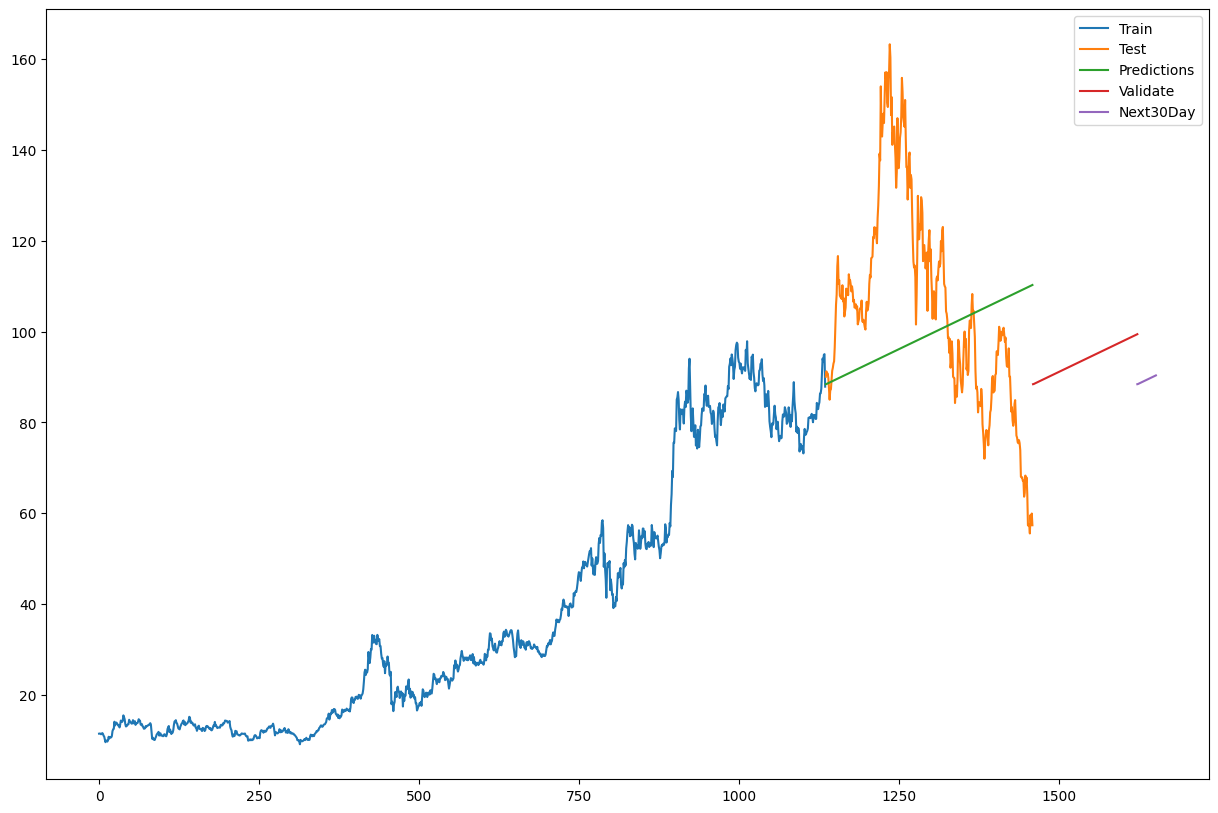

In [15]:
# 9.Vẽ hình
plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Open'])
plt.plot(test_data.index, test_data['Open'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [16]:
test_data.index

RangeIndex(start=1136, stop=1460, step=1)